# Delayed Traffic Prediction Models
This notebook contains delayed regression models to forecast Google Maps travel times. In particular, we use current and historical data to estimate travel times 10 minutes, 30 minutes, 1 hour, and 6 hours in the future.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.utils

%matplotlib inline

data_dir = 'data/'

### Read and Process Data

In [2]:
# Google Traffic travel time data
df = pd.read_csv(data_dir + 'google_traffic/data/gilman1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

# San Diego hourly weather data from Weather Underground
weather_files = sorted(glob.glob(data_dir + 'google_traffic/weather_data/*.csv'))
weather_frames = []
for filename in weather_files:
    hourly_df = pd.read_csv(filename)
    hourly_df['DateUTC'] = pd.to_datetime(hourly_df['DateUTC'])
    weather_frames.append(hourly_df)
    
weather_df = pd.concat(weather_frames, ignore_index=True)
weather_df = weather_df.set_index('DateUTC')
weather_df = weather_df.fillna({'PrecipitationIn': 0})
weather_df.loc[weather_df['Wind SpeedMPH'] == 'Calm', 'Wind SpeedMPH'] = 0
weather_df['Wind SpeedMPH'] = weather_df['Wind SpeedMPH'].astype(float)
weather_df = weather_df.drop(['TimePST', 'Dew PointF', 'Humidity', 'Sea Level PressureIn',
                              'VisibilityMPH', 'Wind Direction', 'Gust SpeedMPH', 'Events',
                              'Conditions', 'WindDirDegrees'], axis=1)

# Join Google Traffic and Weather Underground data
nearest_indices = np.searchsorted(weather_df.index, df.index)
df['WeatherIdx'] = weather_df.index.get_values()[nearest_indices]
merged = pd.merge(df, weather_df, left_on='WeatherIdx', right_index=True)
merged = merged.drop(['WeatherIdx'], axis=1)
df = df.drop(['WeatherIdx'], axis=1)

In [3]:
# Read and process ION data files
ion_files = sorted(glob.glob(data_dir + 'ion_data/data/*.csv'))
ion_frames = []
for i in range(len(ion_files)):
    ion_df = pd.read_csv(ion_files[i], header=None, names=['time', 'value_' + str(i)])
    ion_df['time'] = pd.to_datetime(ion_df['time'])
    ion_df = ion_df.set_index('time')
    ion_frames.append(ion_df)
    
for ion_df in ion_frames:
    indices = np.searchsorted(ion_df.index, merged.index)
    indices[indices == len(ion_df)] = len(ion_df) - 1
    merged['ion_indices'] = ion_df.index.get_values()[indices]
    merged = pd.merge(merged, ion_df, left_on='ion_indices', right_index=True)

### Delayed Autoregression Models

In [4]:
# Plot the model's predictions along with the largest observed anomalies
def plot_with_anomalies(delayed_df, delay_str):
    delayed_df.loc[:, 'errors'] = delayed_df['value'] - delayed_df['predictions']
    errors = delayed_df['errors'].sort_values()
    
    anomalies_X = []
    anomalies_y = []

    for i in range(-10, 0):
        anomalies_X.append(errors.index[i])
        anomalies_y.append(delayed_df['value'][errors.index[i]])

    matplotlib.rcParams.update({'font.size': 13})
    plt.rc('legend', fontsize=10)
    fig = plt.figure(figsize=(15, 2))
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    plt.plot(delayed_df['value'], label='Observed Travel Time')
    plt.plot(delayed_df['predictions'], label='Predicted Travel Time')
    plt.plot(anomalies_X, anomalies_y, 'o', label='Anomalies',
             markeredgecolor='red', markerfacecolor='none')
    plt.title('Autoregression Model with Weather and ION Data, Delay: ' + delay_str)
    plt.xlabel('Date')
    plt.ylabel('Travel Time')
    plt.legend(loc='best')
    plt.show()

# Plot a one-week subset of the model's predictions with the largest observed anomalies
def plot_week_with_anomalies(delayed_df, delay_str):
    delayed_df['errors'] = delayed_df['value'] - delayed_df['predictions']
    week_df = delayed_df[(delayed_df.index >= '2017-01-10') &
                         (delayed_df.index <  '2017-01-17')]
    errors = week_df['errors'].sort_values()
    
    anomalies_X = []
    anomalies_y = []

    for i in range(-10, 0):
        anomalies_X.append(errors.index[i])
        anomalies_y.append(week_df['value'][errors.index[i]])
        
    matplotlib.rcParams.update({'font.size': 13})
    plt.rc('legend', fontsize=10)
    fig = plt.figure(figsize=(10, 5))
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    plt.plot(week_df['value'], label='Observed Travel Time', linewidth=3)
    plt.plot(week_df['predictions'], label='Predicted Travel Time', linewidth=3)
    plt.plot(anomalies_X, anomalies_y, 'o', label='Anomalies',
             markeredgecolor='red', markerfacecolor='none', markersize=10,
             markeredgewidth=1)
    plt.title('Autoregression Model with Weather and ION Data, Delay: ' + delay_str)
    plt.xlabel('Date')
    plt.ylabel('Travel Time')
    plt.legend(loc='best')
    plt.show()

In [5]:
# Insert previously observed travel time features (autoregression terms)
for i in range(1, 6):
    merged['prev_' + str(i)] = merged.value.shift(i)
merged = merged.iloc[5:]

# Create list of feature columns
cols = ['value_' + str(i) for i in range(len(ion_frames))]
cols += ['TemperatureF', 'Wind SpeedMPH', 'PrecipitationIn']
cols += ['prev_' + str(i) for i in range(1, 6)]

Delay: 10 Minutes
	Overall RMSE: 17.1671389921
	Number of nonzero features: 748
	Train RMSE:   16.2621577259
	Test RMSE:    23.6221693033


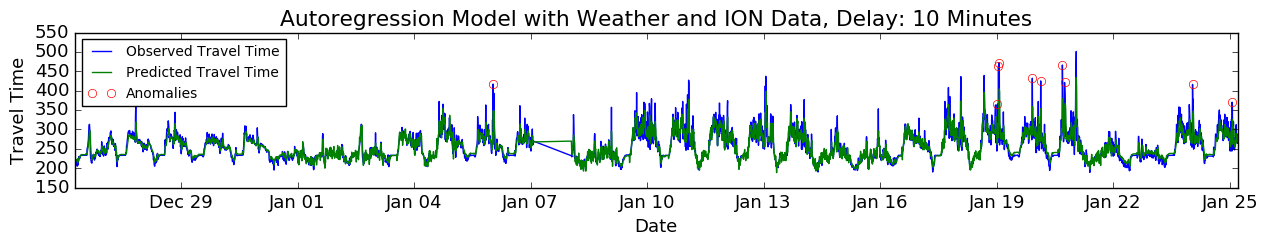

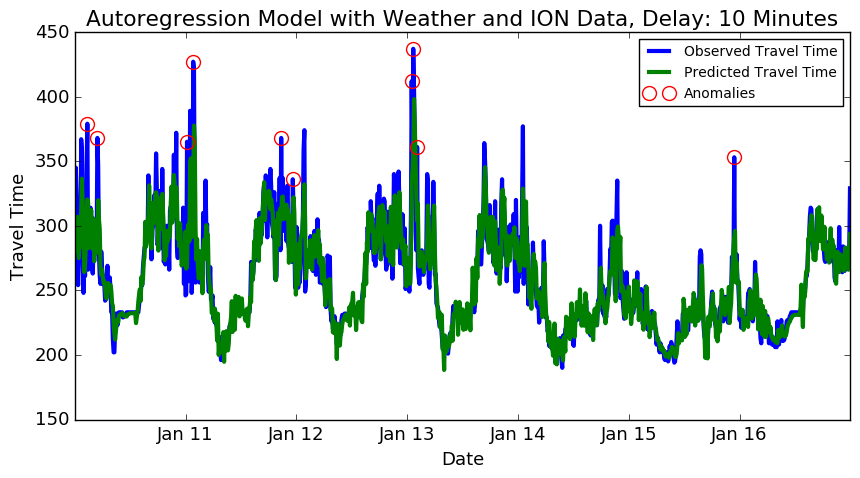

Delay: 30 Minutes
	Overall RMSE: 20.1112896067
	Number of nonzero features: 770
	Train RMSE:   19.7440288089
	Test RMSE:    25.0439847563


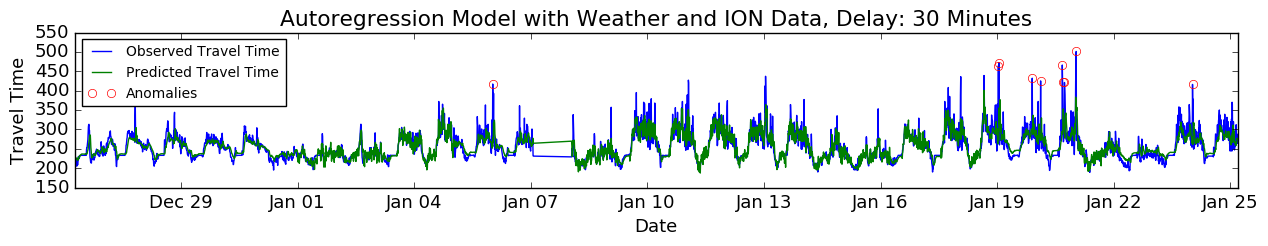

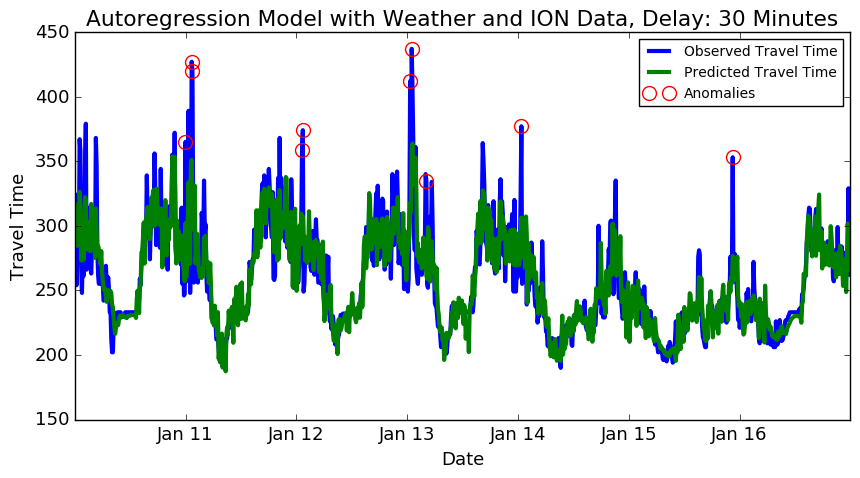

Delay: 1 Hour
	Overall RMSE: 21.2591473751
	Number of nonzero features: 775
	Train RMSE:   20.9676013268
	Test RMSE:    25.8693380396


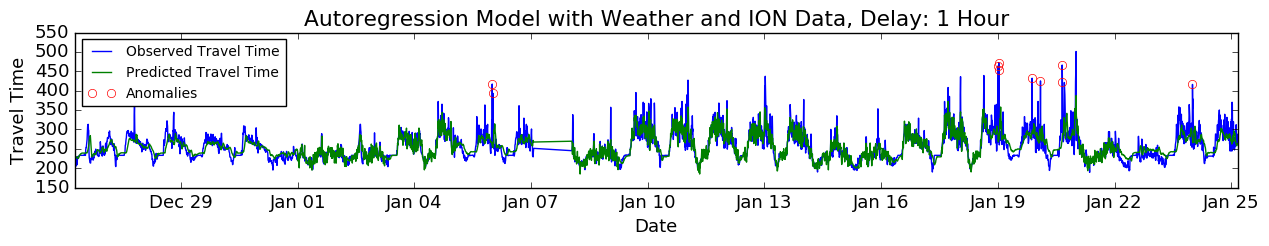

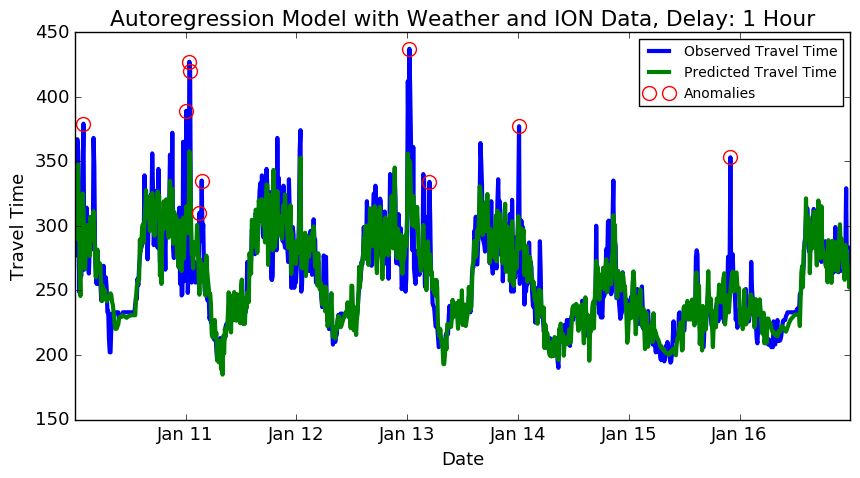

Delay: 6 Hours
	Overall RMSE: 26.1764486187
	Number of nonzero features: 762
	Train RMSE:   26.0730773208
	Test RMSE:    29.1092692592


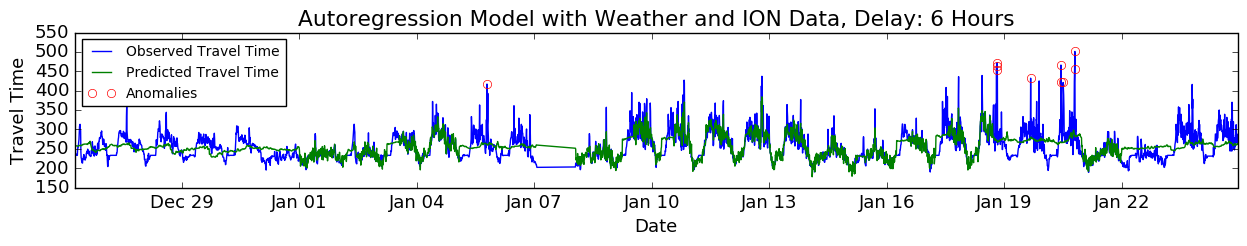

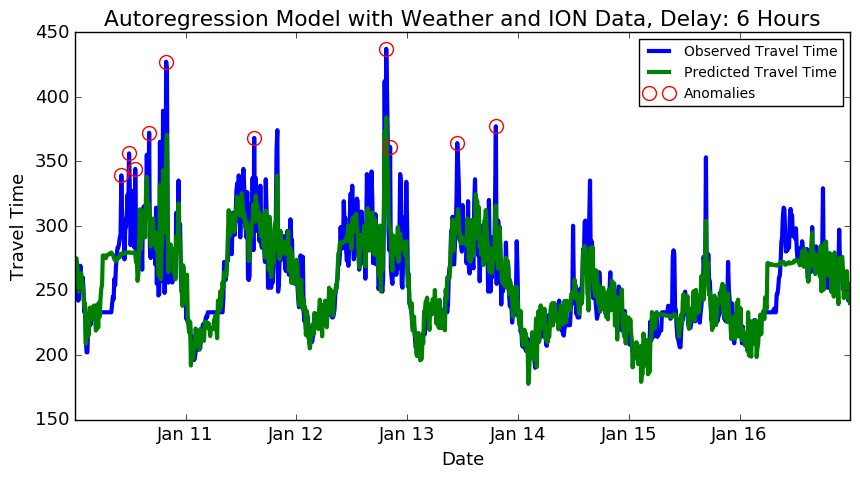

In [7]:
# Train delayed lasso regression models to forecast Google Traffic travel time
# values. The delay in the original data is 10 minutes, so shifting the values
# by 2, 5, and 35 places leads to a forecasting delay of 30 min, 1 hour, and 6
# hours respectively.
for delay, delay_str in [(0, '10 Minutes'), (2, '30 Minutes'),
                         (5, '1 Hour'), (35, '6 Hours')]:
    print 'Delay: ' + delay_str
    delayed_df = merged.copy()
    
    if delay > 0:
        delayed_df['value'] = delayed_df['value'].shift(-delay)
        delayed_df = delayed_df.iloc[:-delay]
    
    X = delayed_df[cols].values
    y = delayed_df['value'].values
    
    # Train model and compute RMSE over the entire dataset
    clf = sklearn.linear_model.Lasso(alpha=0.01)
    clf.fit(X, y)
    delayed_df['predictions'] = clf.predict(X)
    rmse = np.sqrt(np.mean((clf.predict(X) - y)**2))
    print '\tOverall RMSE: ' + str(rmse)

    num_nonzero = sum([1 for i in clf.coef_ if i != 0.0])
    print '\tNumber of nonzero features: ' + str(num_nonzero)
    
    # Train model and compute RMSE over separate training and test datasets
    X, y = sklearn.utils.shuffle(X, y, random_state=0)
    X_train = X[:int(0.8*len(X))]
    y_train = y[:int(0.8*len(y))]
    X_test = X[int(0.8*len(X)):]
    y_test = y[int(0.8*len(y)):]
    
    clf = sklearn.linear_model.Lasso(alpha=0.01)
    clf.fit(X_train, y_train)
    train_rmse = np.sqrt(np.mean((clf.predict(X_train) - y_train)**2))
    test_rmse = np.sqrt(np.mean((clf.predict(X_test) - y_test)**2))
    print '\tTrain RMSE:   ' + str(train_rmse)
    print '\tTest RMSE:    ' + str(test_rmse)
    
    # Plot model predictions
    plot_with_anomalies(delayed_df, delay_str)
    plot_week_with_anomalies(delayed_df, delay_str)